# Conditional stochastic landmark model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.icml2024())
from flax import nnx

from neuralbridge.sdes.examples import LandmarkGaussianSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedProposalSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import load
from neuralbridge.utils.pcn import PCNSampler

In [3]:
def sampling_ellipse(n, a, b, rotation, shift_x, shift_y):
    u = jnp.linspace(0.0, 2.0 * jnp.pi, n, endpoint=False)
    x = a * jnp.sin(u)
    y = b * jnp.cos(u)
    x_rot = x * jnp.cos(rotation) - y * jnp.sin(rotation) 
    y_rot = x * jnp.sin(rotation) + y * jnp.cos(rotation)
    x_shift = x_rot + shift_x
    y_shift = y_rot + shift_y
    u = jnp.concatenate([x_shift, y_shift], axis=0)
    return u

In [50]:
sde = LandmarkGaussianSDE(
    params={
        "k_alpha": 1.5,
        "k_sigma": 0.5,
        "n": 50,
        "m": 2
    }
)

x0 = sampling_ellipse(n=sde.n, a=1.0, b=0.5, rotation=0.0, shift_x=0.0, shift_y=0.0)
vT = sampling_ellipse(n=sde.n, a=1.0, b=0.5, rotation=jnp.pi / 3, shift_x=-1.0, shift_y=0.5)

In [51]:
sde_solver = SDESolver(sde, 'milstein')
ts = jnp.linspace(0.0, 1.0, 100+1)
sde_traj = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 4)
print(sde_traj.shape)

(4, 101, 100)


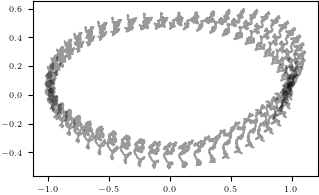

In [52]:
sde_traj = sde_traj.reshape(4, 101, 2, -1)
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(sde_traj[0, :, 0, i], sde_traj[0, :, 1, i], color="black", alpha=0.4)


In [53]:
sde = LandmarkGaussianSDE(
    params={
        "k_alpha": 1.5,
        "k_sigma": 0.5,
        "n": 10,
        "m": 2
    }
)

x0 = sampling_ellipse(n=sde.n, a=1.0, b=0.5, rotation=0.0, shift_x=0.0, shift_y=0.0)
vT = sampling_ellipse(n=sde.n, a=1.0, b=0.5, rotation=jnp.pi / 3, shift_x=-1.0, shift_y=0.5)

In [54]:
sde_solver = SDESolver(sde, 'milstein')
ts = jnp.linspace(0.0, 1.0, 100+1)
sde_traj = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 4)
print(sde_traj.shape)

(4, 101, 20)


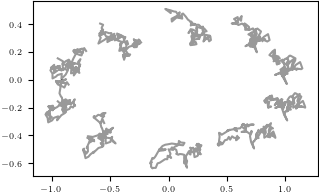

In [55]:
sde_traj = sde_traj.reshape(4, 101, 2, -1)
fig, ax = plt.subplots()

for i in range(10):
    ax.plot(sde_traj[0, :, 0, i], sde_traj[0, :, 1, i], color="black", alpha=0.4)

In [12]:
q_half_0 = LandmarkGaussianSDE.compute_q_half(x0, sde.m, sde.n, 0.3, 0.5)
q_half_T = LandmarkGaussianSDE.compute_q_half(vT, sde.m, sde.n, 0.3, 0.5)

aux_sde = AuxiliarySDE(
    dim_x=sde.dim_x,
    dim_w=sde.dim_w,
    coeffs={
        'T': 1.0,
        'beta': lambda t: jnp.zeros((sde.dim_x, )),
        'B': lambda t: jnp.zeros((sde.dim_x, sde.dim_x)),
        'a_tilde': None,
        'a_tilde_0': q_half_0 @ q_half_0.T,
        'a_tilde_T': q_half_T @ q_half_T.T
    }
)

epsilon = 2e-3
guided_sde = GuidedProposalSDE(
    sde, aux_sde,
    obs_params={
        'vT': vT,
        'LT': jnp.eye(sde.dim_x),
        'SigmaT': epsilon * jnp.eye(sde.dim_x)
    },
    ts=ts,
    eq_type="close"
)

(4, 101, 100)


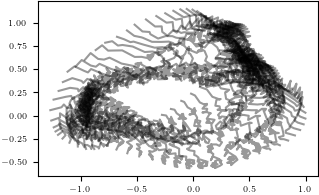

In [13]:
guided_solver = SDESolver(guided_sde, 'milstein')
guided_traj = guided_solver.batch_solve(jr.PRNGKey(42), x0, ts, 4)
print(guided_traj.shape)
guided_traj = guided_traj.reshape(4, 101, 2, -1)
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(guided_traj[0, :, 0, i], guided_traj[0, :, 1, i], color="black", alpha=0.4)

In [14]:
b_fn = guided_sde.b
sigma_fn = guided_sde.sigma
G_fn = guided_sde.G

rngs = nnx.Rngs(42)
nn_config = {
    'model_name': 'MLPMedium',
    'input_dim': 100,
    'output_dim': 100,
    'hidden_dims': [256, 256, 256, 128],
    't_emb_type': 'sinusoidal',
    't_emb_kwargs': {
        'embed_dim': 64,
        'scale': 100.0,
        'max_freq': 1000.0,
        'min_freq': 1.0,
        'rngs': rngs
    },
    'act_type': 'lipswish',
    'rngs': rngs
}

neural_bridge = NeuralBridge(
    b_fn, sigma_fn, G_fn, nn_config
)   

In [15]:
load(neural_bridge, "../assets/ckpts/neural_bridge/landmark/k_alpha_0.3_k_sigma_0.5_n_50_m_2/")

Loaded latest model from step 10000


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [18]:
nb_solver = SDESolver(neural_bridge, 'milstein')

n_samples = 4
nb_traj = nb_solver.batch_solve(jr.PRNGKey(2), x0, ts, n_samples)
nb_traj = nb_traj.reshape(n_samples, 101, 2, -1)

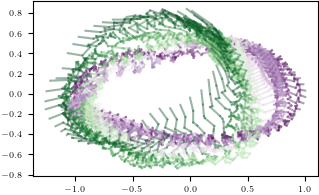

In [19]:
cmap = plt.get_cmap('PRGn')
colors = cmap(ts)

fig, ax = plt.subplots()
for i in range(1):
    for j in range(nb_traj.shape[-1]):
        for t in range(nb_traj.shape[1]-1):
            ax.plot(nb_traj[i, t:t+2, 0, j], nb_traj[i, t:t+2, 1, j], 
                   color=colors[t], alpha=0.4)